# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
You should consider upgrading via the 'c:\users\ander\appdata\local\programs\python\python39-32\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip list

Package             Version
------------------- -----------
contourpy           1.2.1
cycler              0.12.1
fonttools           4.51.0
importlib-resources 6.4.0
kiwisolver          1.4.5
matplotlib          3.8.4
numpy               1.26.4
opencv-python       4.9.0.80
packaging           24.0
pillow              10.3.0
pip                 20.2.3
pyparsing           3.1.2
python-dateutil     2.9.0.post0
setuptools          49.2.1
six                 1.16.0
zipp                3.18.1


You should consider upgrading via the 'c:\users\ander\appdata\local\programs\python\python39-32\python.exe -m pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 854 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

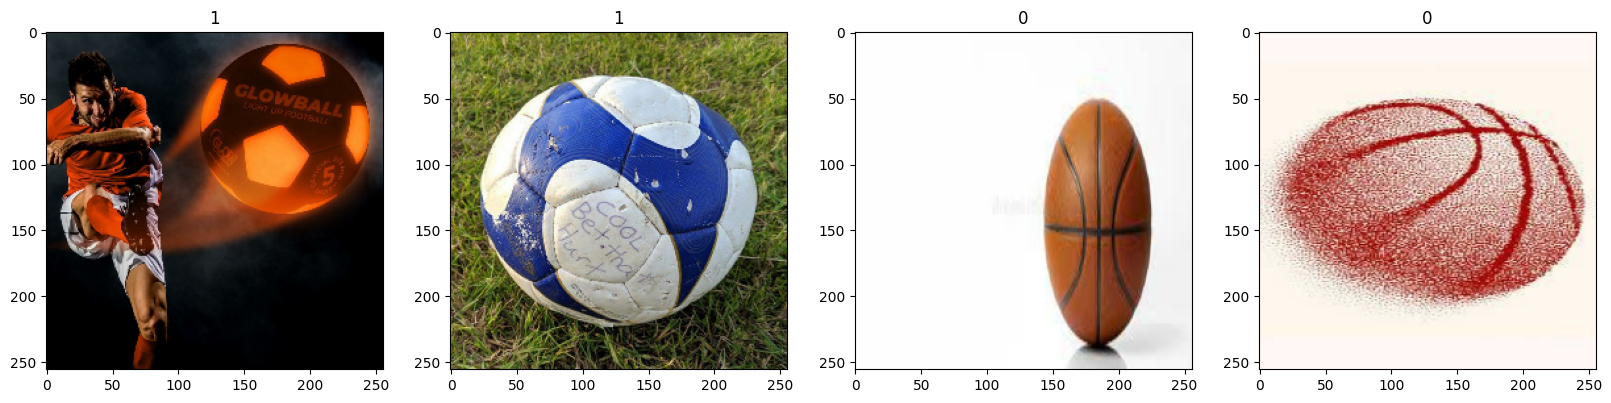

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

# 5. Split Data

In [17]:
len(data)

27

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1 
test_size = int(len(data)*.1)+1

In [19]:
print(test_size, val_size, train_size)

3 6 18


In [20]:
train_size + val_size + test_size

27

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [22]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [28]:
logdir='logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25


18/18 [==============================] - 12s 580ms/step - loss: 0.9192 - accuracy: 0.5938 - val_loss: 0.6529 - val_accuracy: 0.6094
Epoch 2/25
18/18 [==============================] - 11s 562ms/step - loss: 0.5400 - accuracy: 0.7309 - val_loss: 0.5506 - val_accuracy: 0.7135
Epoch 3/25
18/18 [==============================] - 12s 676ms/step - loss: 0.4054 - accuracy: 0.8333 - val_loss: 0.4615 - val_accuracy: 0.7812
Epoch 4/25
18/18 [==============================] - 16s 866ms/step - loss: 0.3248 - accuracy: 0.8889 - val_loss: 0.3149 - val_accuracy: 0.8854
Epoch 5/25
18/18 [==============================] - 18s 974ms/step - loss: 0.2711 - accuracy: 0.8976 - val_loss: 0.3023 - val_accuracy: 0.8854
Epoch 6/25
18/18 [==============================] - 18s 975ms/step - loss: 0.2064 - accuracy: 0.9410 - val_loss: 0.3905 - val_accuracy: 0.8385
Epoch 7/25
18/18 [==============================] - 12s 584ms/step - loss: 0.1745 - accuracy: 0.9462 - val_loss: 0.3308 - val_accuracy: 0.8802
Epoch 8/25

# 8. Plot Performance

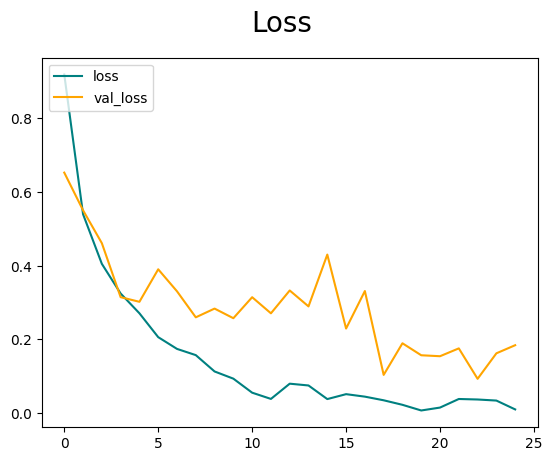

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

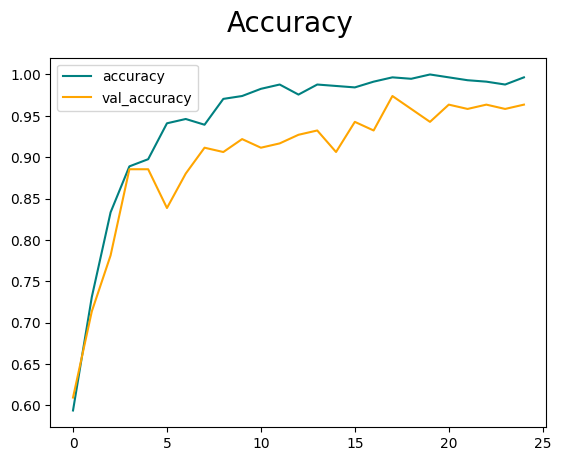

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [35]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 204ms/step


In [36]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9183673, shape=(), dtype=float32) tf.Tensor(0.9782609, shape=(), dtype=float32) tf.Tensor(0.94186044, shape=(), dtype=float32)


# 10. Test

In [37]:
import cv2, random

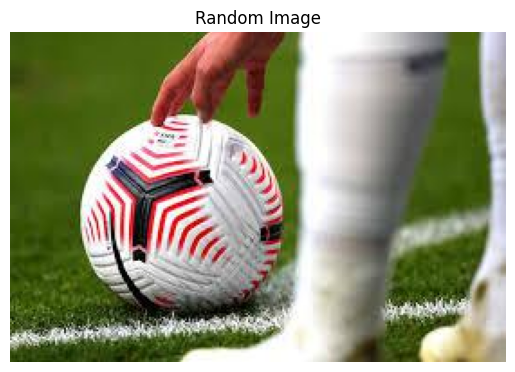

"\nimg = cv2.imread('two.jpeg')\nplt.imshow(img)\nplt.show()\n"

In [74]:
image_dir = "test/football"

# Get list of image filenames
image_files = os.listdir(image_dir)

# Pick a random image file
random_image_file = random.choice(image_files)

# Load the random image
img = cv2.imread(os.path.join(image_dir, random_image_file))

# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.title("Random Image")
plt.axis('off')
plt.show()

"""
img = cv2.imread('two.jpeg')
plt.imshow(img)
plt.show()
"""

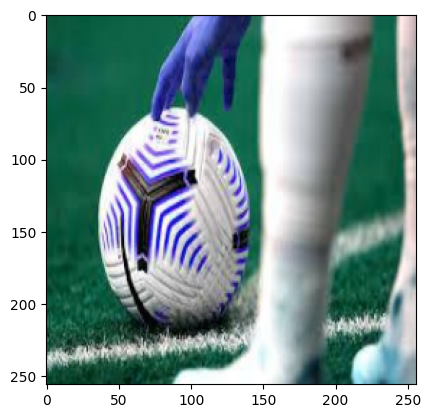

In [75]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [76]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 47ms/step


In [77]:
yhat

array([[0.9980761]], dtype=float32)

In [78]:
if yhat > 0.5: 
    print(f'Predicted class is football')
else:
    print(f'Predicted class is basketball')

Predicted class is football


# 11. Save the Model

In [79]:
from tensorflow.keras.models import load_model

In [80]:
model.save(os.path.join('models','image_classifier.h5'))

In [81]:
new_model = load_model('image_classifier.h5')

In [82]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 121ms/step


array([[0.934276]], dtype=float32)

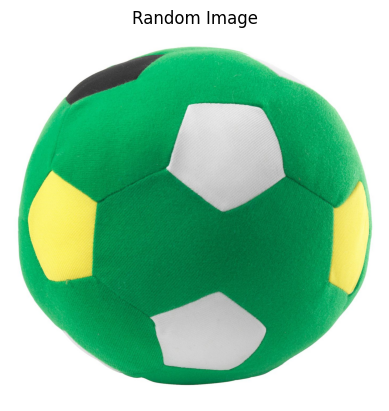

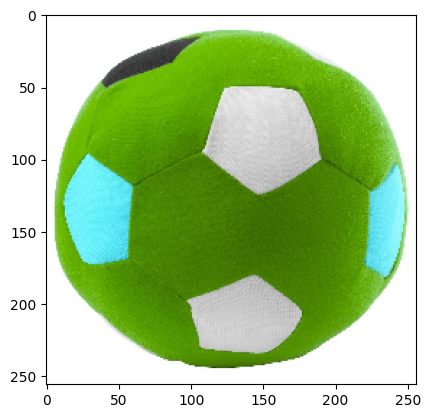

In [97]:
image_dir = "test/football"

# Get list of image filenames
image_files = os.listdir(image_dir)

# Pick a random image file
random_image_file = random.choice(image_files)

# Load the random image
img = cv2.imread(os.path.join(image_dir, random_image_file))

# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.title("Random Image")
plt.axis('off')
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [98]:
yhat = model.predict(np.expand_dims(resize/255, 0)) 

if yhat > 0.5: 
    print(f'Predicted class is football')
else:
    print(f'Predicted class is basketball')
print(yhat)

1/1 [==============================] - 0s 110ms/step
Predicted class is football
[[0.9999998]]
